# Practical example


### The problem

Consider an individual who wants to maximize the expected utility from consuming in two periods. Utility from consuming in the second period is discounted by factor $\beta$. Initial wealth $w$ is allocated across consumption in the first period $c_1$ and savings $s$. Consumption in the second period is the sum of after-return savings $Rs$ and labor income, which with probability $p$ takes a low value $y_l$ and a high value $y_h$ otherwise. Therefore the agent solves

$$ \max_{c_1,s} u(c_1) + \beta \mathbb{E}\big[u(c_2)\big]  $$

such that

$$ 
\begin{aligned}
w &= c_1 + s \\
Rs + y &= c_2\\
y &= \begin{cases}
y_l \quad \text{with probability} \ p \\
y_h \quad \text{with probability} \ 1-p
\end{cases} 
\end{aligned}
$$

Of course, due to the first constraint, $c_1$ and $s$ are not independent choice variables. So we can write our problem in one variable:

$$ \max_{c_1} u(c_1) + \beta \mathbb{E}\Big[u\big(R(w-c_1) + y\big)\Big]  $$

To make the problem more concrete, let's assume that the utility function is of the CRRA kind, so

$$ u(c) = \frac{c^{1-\gamma}-1}{1-\gamma} $$

where $\gamma$ is the risk aversion parameter.

### Define the problem in Julia

First, we put all parameters in a structure. Then we define a function assigning the expected total utility for any policy choice

In [32]:
#using Pkg
#Pkg.add("Parameters") # run if first time
using Parameters

@with_kw struct Problem
    w = 1.0
    R = 1.02
    p = 0.5
    y_l = 0.8
    y_h = 1.2
    β = 0.98
    γ = 2.0
end

u(c,γ) = (c^(1-γ)-1)/(1-γ)

function value(c1::Real, prob::Problem)
    @unpack_Problem prob
    s = w - c1
    v(c) = u(c,γ) 
    return v(c1) + β * (p * v(R * s + y_l) + (1-p) * v(R * s + y_h))
end 


value (generic function with 1 method)

How to write greek letters in Julia?
1. write `\`
2. start typing the name of the greek letter (gamma in this case)
3. press `Tab`

How does this work?

In [2]:
benchmark = Problem() # initializes the problem with default parameter values
println(benchmark)

rich = Problem(w = 2.0) # initializes another problem by overwriting the default value for w
println(rich)

value(1.0, benchmark) < value(1.0, rich) # returns true if rich is happier than benchmark assuming equal consumption in first period

Problem
  w: Float64 1.0
  R: Float64 1.02
  p: Float64 0.5
  y_l: Float64 0.8
  y_h: Float64 1.2
  β: Float64 0.98
  γ: Float64 2.0

Problem
  w: Float64 2.0
  R: Float64 1.02
  p: Float64 0.5
  y_l: Float64 0.8
  y_h: Float64 1.2
  β: Float64 0.98
  γ: Float64 2.0



true

### Gaining intuition on optimal consumption decision

##### What is the range of sensible consumption decisions? 

CRRA has the nice property that $\lim_{c->0} u'(c) = \infty $, so we can expect an optimal decision to ensure strictly positive consumption in both periods in any state of nature. Therefore
 * $c_1>0$ 
 * $c_1<w + \frac{y_l}{R}$ (otherwise $c_2$ would not be positive if low income is earned in the second period). 
Since we will repeatedly need the maximum consumption value, of course it belongs to a function.


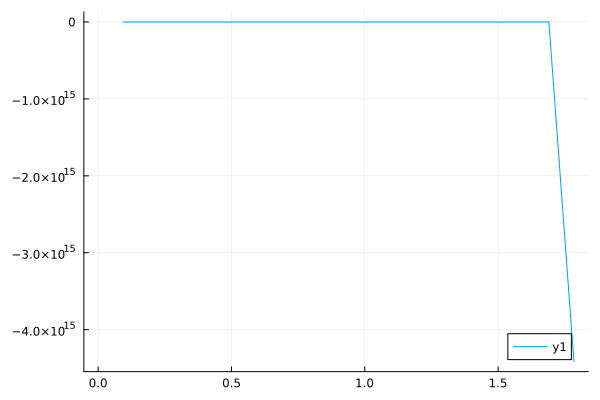

In [3]:
maxcons(prob::Problem) = prob.w + prob.y_l/prob.R

candidates = range(0, maxcons(benchmark); length = 20)

values = [value(candidate,benchmark) for candidate in candidates]
# for reference one could also run
# values = value.(candidates,[benchmark])

#Pkg.add("Plots")
using Plots # this loads the package to plot
gr() # this activates a 'backend' 

plot(candidates, values)


Oh-oh, this plot is useless. Let's tell plot to focus on a particular range of values

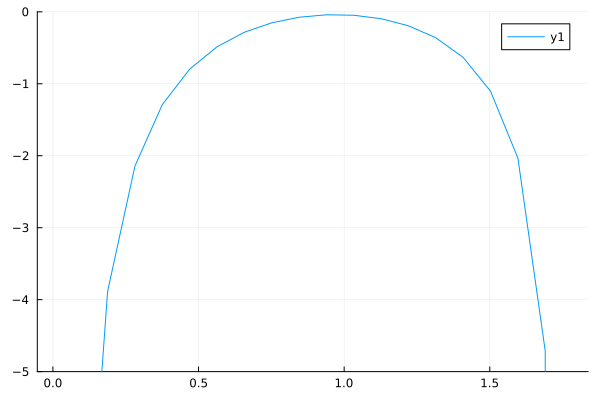

In [33]:
plot(candidates, values, ylims = [-5.0,0.0])


Let's make this prettier!

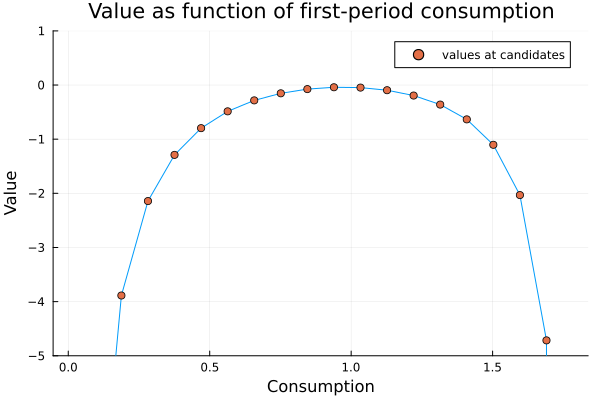

In [35]:
plot(candidates, values, ylims = [-5.0,1.0], title = "Value as function of first-period consumption", xlabel = "Consumption", ylabel = "Value", label = "")
scatter!(candidates, values, label = "values at candidates")


##### Some take-aways

* The maximum seems to be somewhere around $1$ for these particular set of parameters (is this surprising?)
* The value function looks concave. In fact, it can easily be proved to be concave. Why is this useful to know? 

### Solve the problem using the first-order condition

We know that at the maximum the derivative of the value function has to be zero. In other words, the first-order condition

$$ 0 = u'(c_1) - \beta R \mathbb{E}\Big[u'\big(R(w-c_1) + y\big)\Big] $$

holds at any local optimum. Since the value function is concave, there is only one such point, which is the global optimum.

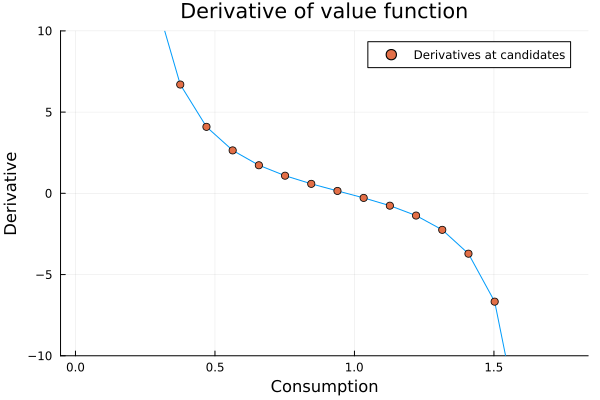

In [36]:
u_d(c,γ) = c^(-γ)

function value_d(c1::Real, prob::Problem)
    @unpack_Problem prob
    s = w - c1
    v_d(c) = u_d(c,γ) 
    return v_d(c1) - β * R * (p * v_d(R * s + y_l) + (1-p) * v_d(R * s + y_h))
end

derivatives = [value_d(candidate,benchmark) for candidate in candidates]

plot(candidates, derivatives, ylims = [-10.0,10.0], title = "Derivative of value function", xlabel = "Consumption", ylabel = "Derivative", label = "")
scatter!(candidates, derivatives, label = "Derivatives at candidates")

Again we see that optimum is somewhere close to $1$.

#### How to solve equations in Julia?

What we want is a machine with the following capability: if we give any function as input, it gives us a point **close enough** to **some** root of the function in question (if there is a root of course). Of course, such tools are available in Julia, but to get some intuition on what they do, first we write our own! The simplest algorithm to find the root of a function is bisection.

##### Bisection

We are given a function $f$ and want to know its root. 
 1) To get started we need a point $a$ such that  $f(a) < 0$ and another ($b$) where $f(b) > 0$ holds. Without loss of generality, we can assume $a<b$.
 2) Consider 
 $$ c = \frac{a+b}{2} $$
 We have three possibilities:
  - if $f(c) = 0$, we are done. Naturally, this never happens.
  - if $f(c)>0$, then $b$ can be discarded and replaced by $c$. Return to beginning of 2).
  - if $f(c)<0$, then $a$ can be discarded and replaced by $c$. Return to beginning of 2).
 3) Repeat point 2) until in some sense we are close enough to the solution. Close enough means that either $|b-a|$ or $|f(b)-f(a)|$ is smaller than some given small number.

In [7]:
function bisection(f,a,b; ϵ = 10^-7)
    if f(a)*f(b) > 0
        throw(DomainError("initial interval is not a bracketing one"))
    end

    dif = abs(b-a)
    while dif > ϵ
        c = (a+b)/2
        fc = f(c)
        if fc == 0.0
            return c
        elseif fc*f(a) > 0.0
            a = c
        else
            b = c
        end
        dif = abs(b-a)
    end
    return a
end

benchmark_sol = bisection(c1->value_d(c1, benchmark), 0.0, maxcons(benchmark))


0.9718408607969096

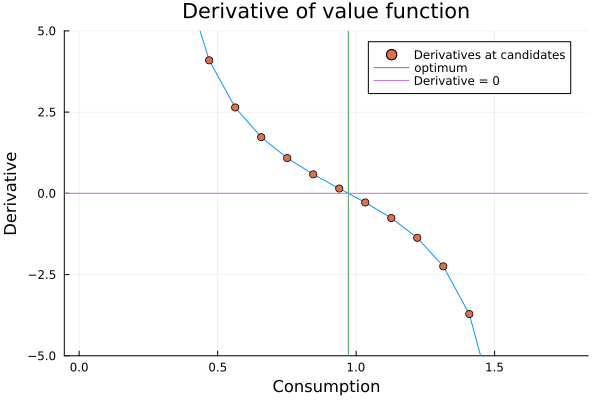

In [8]:
plot(candidates, derivatives, ylims = [-5.0,5.0], title = "Derivative of value function", xlabel = "Consumption", ylabel = "Derivative", label = "")
scatter!(candidates, derivatives, label = "Derivatives at candidates")
vline!([benchmark_sol], label = "optimum")
hline!([0.0], label = "Derivative = 0")

#### Some thoughts on bisection and numerical procedures in general

 - We cannot get the exact solution. Instead, we obtain a point which is close to the true solution in some sense. We have control over how close. Trade-off: accuracy vs time. In the end however, accuracy is limited by your hardware, since numbers are represented by finitely many bits.
 - When starting from a bracketing interval, this algorithm always converges to a root. This can be proved using on the Intermediate Value Theorem (AKA Bolzano's Theorem).
 - What happens the function in question has more than one roots? The algorithm would give us an approximate solution of **one of the roots**. It would **not** tell us that there might be other roots.

Of course, there are other (faster) algorithms than bisection. Note that most other algorithms do not guarantee convergence based on theoretical grounds, but are more heuristic (i.e. they don't always work). There is no generalisation of bisection to several dimensions (to solve a system of equations).

##### Remember:
 - The only thing numerical algorithms do is to evaluate the function in question at certain points. Algorithms differ in how they 'decide' which point to evaluate next, based on results form previous evaluations. Note that even if these points are chosen in some sophisticated way, the computer does not **understand** your problem in any way. That's your job!
 - You have to make sure that the solution given by the computer makes sense as a solution to your problem. Thinking over the following questions is a good idea **before** coding: 
     * Does your problem have any sensible solution for the parameter values you consider?
     * Does your problem have only one sensible solution?
     * Is there a reason to think the algorithm will find the solution you are interested in?
     * What level of accuracy do you need?
     
   and **after** running your code:
     * Does the solution you get seem sensible?


#### Other Algorithms 

 - Derivative-free methods, eg bisection and the secant method (GIF: https://upload.wikimedia.org/wikipedia/commons/b/be/Metodo_delle_secanti.gif)
 - Derivative-based methods. The idea is the slope of the function is a very valuable piece of information when you are looking for where it crosses the $f(x)=0$ line.
 Hence these methods in general require fewer steps. On the other hand, for each step you need to evaluate the derivative besides the function itself, so it is not always worth it. A classical example is Newton-Raphson (GIF: https://upload.wikimedia.org/wikipedia/commons/e/e0/NewtonIteration_Ani.gif).

In both groups there are other more modern (and more efficient) methods, besides these classical examples. Note that some of these algorithms need a bracketing interval to get started (bisection), others need only an initial point.

#### Root-solving in Julia

Two important packages:
 - Roots.jl (https://juliamath.github.io/Roots.jl/stable/) for univariate functions. When using a method relying on derivatives, you need to supply a separate function to compute the derivative. 
 - NLsolve.jl (https://github.com/JuliaNLSolvers/NLsolve.jl?tab=readme-ov-file) for multivariate functions, i.e. to solve systems of equations (can be used with univariate as well, but for that using Roots is slightly simpler). When using a method relying on derivatives, you either supply it as a separate function or Julia will approximate it. 

We'll take a look at Roots.jl now. Find a guide to use NLsolve in the end of this notebook. I'm not sure we'll need it in this course.

#### Roots

In [9]:
# Pkg.add("Roots")
using Roots

sol = find_zero(c1->value_d(c1, benchmark), (0.0, maxcons(benchmark)))

0.9718408845137831

Note the arguments of find_zero:
 - First argument is the function that we want to root of. Here we gave it as an anonymous function
 - Second argument is a bracketing interval around a root. Given as a tuple.
 - We didn't need to specify the algorithm, since when a tuple is given as a start, bisection is the default method anyways.  


This is how to show some info about how the optimum was found:

In [10]:
find_zero(c1->value_d(c1, benchmark), (0.0, maxcons(benchmark)), verbose = true) # gives long output. 'verbose' is a keyword argument which defaults to 'false'.

Results of univariate zero finding:

* Converged to: 0.9718408845137831
* Algorithm: Bisection()
* iterations: 61
* function evaluations ≈ 64
* stopped as x_n ≈ x_{n-1} using atol=xatol, rtol=xrtol

Trace:
(a₀, b₀) = ( 1.4112350599231763e-154, 1.784313725490196 )
(a₁, b₁) = ( 1.5875309843923611e-77, 1.784313725490196 )
(a₂, b₂) = ( 5.3228573851572939e-39, 1.784313725490196 )
(a₃, b₃) = ( 9.7458614401730077e-20, 1.784313725490196 )
(a₄, b₄) = ( 4.170122373776108e-10, 1.784313725490196 )
(a₅, b₅) = ( 2.7277890373678764e-05, 1.784313725490196 )
(a₆, b₆) = ( 0.0069765577129289203, 1.784313725490196 )
(a₇, b₇) = ( 0.11157226562499999, 1.784313725490196 )
(a₈, b₈) = ( 0.44618374693627444, 1.784313725490196 )
(a₉, b₉) = ( 0.89226217830882337, 1.784313725490196 )
(a₁₀, b₁₀) = ( 0.89226217830882337, 1.2844190410539214 )
(a₁₁, b₁₁) = ( 0.89226217830882337, 1.034471698835784 )
(a₁₂, b₁₂) = ( 0.95474901386335764, 1.034471698835784 )
(a₁₃, b₁₃) = ( 0.95474901386335764, 0.98599243164062478 )
(a₁₄, b

0.9718408845137831

Order16 is a more modern, derivative-free method requiring a starting point only (here we use the halving point of the feasible region). We get to the solution in fewer steps:

In [11]:
find_zero(c1->value_d(c1, benchmark),  maxcons(benchmark)/2, verbose = true, Order16()) # using the 'Order16' method. Note that in this case a starting point is given instead of an initial interval

Results of univariate zero finding:

* Converged to: 0.9718408845137833
* Algorithm: Order16()
* iterations: 3
* function evaluations ≈ 8
* Note: Approximate derivative failed

Trace:
x₁ = 0.89216291823226446,	 fx₁ = 0.36154994401837259
x₂ = 0.89215686274509798,	 fx₂ = 0.36157793863708976
x₃ = 0.97036941456514603,	 fx₃ = 0.006649698951574301
x₄ = 0.97183475281013476,	 fx₄ = 2.7715199967248694e-05
x₅ = 0.97184088451378325,	 fx₅ = -6.6613381477509392e-16



0.9718408845137833

Next we try a derivative-based method, so we need a function to compute the derivative of value_d (so the second derivative of the value function)

In [12]:
u_dd(c,γ) = -γ*c^(-γ-1)

function value_dd(c1::Real, prob::Problem)
    @unpack_Problem prob
    s = w - c1
    v_dd(c) = u_dd(c,γ) 
    return v_dd(c1) + β * R^2 * (p * v_dd(R * s + y_l) + (1-p) * v_dd(R * s + y_h))
end

find_zero((c1->value_d(c1, benchmark),c1->value_dd(c1, benchmark)),  maxcons(benchmark)/2, verbose = true, Roots.Newton())

# now we needed to give a tuple containing two functions: the function of interest and its derivative!

Results of univariate zero finding:

* Converged to: 0.9718408845137831
* Algorithm: Roots.Newton()
* iterations: 4
* function evaluations ≈ 8
* stopped as |f(x_n)| ≤ max(δ, |x|⋅ϵ) using δ = atol, ϵ = rtol

Trace:
x₁ = 0.89215686274509798,	 fx₁ = 0.36157793863708976
x₂ = 0.97036921676268095,	 fx₂ = 0.0066505926641340363
x₃ = 0.97184117062839293,	 fx₃ = -1.2932344997107492e-06
x₄ = 0.97184088451379458,	 fx₄ = -5.1514348342607263e-14
x₅ = 0.97184088451378314,	 fx₅ = 2.2204460492503131e-16



0.9718408845137831

##### A warning on multiple roots

When the function in question has several roots, in general it depends on pure luck, which one of them any algorithm would find.

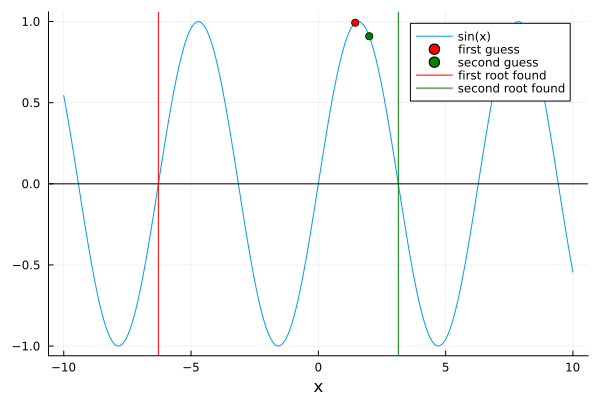

In [13]:
xgrid = range(-10.0,10.0, length = 200)
plot(xgrid,sin.(xgrid),label = "sin(x)", xlabel = "x", legend = :topright)
guess_1 = 1.45
guess_2 = 2.0
sol_1 = find_zero(sin,  guess_1, Order16())
sol_2 = find_zero(sin,  guess_2, Order16())
scatter!([guess_1],[sin(guess_1)], label = "first guess", color = :red)
scatter!([guess_2],[sin(guess_2)], label = "second guess", color = :green)
vline!([sol_1], label = "first root found", color = :red)
vline!([sol_2], label = "second root found", color = :green)
hline!([0.0], label = "", color = :black )

#### Optimization in Julia

Of course, instead of working with the first order condition, we could just maximize the value function directly. There are three packages in Julia to optimize function that are useful to know:
 - Optim (http://julianlsolvers.github.io/Optim.jl/stable/#) has the most user-friendly interface, so we will use that one now. Has a lot of algorithms, but sadly little support for constrained optimization.
 - NLopt (https://juliapackages.com/p/nlopt and https://nlopt.readthedocs.io/en/latest/NLopt_Introduction/) is more cumbersome to use and misses some algorithms utilizing derivatives and Hessians which can be found in Optim. However, it has full support for constained optimization.
 - Optimization (https://docs.sciml.ai/Optimization/stable/) is not really an independent package, but provides a common interface to Optim, NLopt and many other optmization packages in Julia. Slightly more complicated to use than Optim, so we skip it for now, but very useful to know if you are planning to use Julia in the future.

##### Types of algorithms

- Derivative-free methods: only needs the function itself to run. Generally robust, but slow. One example is Nelder-Mead (GIF: https://upload.wikimedia.org/wikipedia/commons/e/e4/Nelder-Mead_Rosenbrock.gif)
- Derivative-based methods. Idea: gradient points towards highest ascent. Two choices: Either you provide a function to compute the derivative of your function, or Julia will approximate it. Can be significantly faster than derivative-free methods, since much fewer steps are needed. Of course, if the derivative is expensive to evaluate (or to approximate), it can backfire. Same if approximation is not good enough. Definitely a bad idea, if the function to optimize is not smooth.
- Hessian-based methods: also needs second-order derivatives. Idea: approximate your function with a parabola, and take the maximum/minimum of that as your next guess. Same comments apply as for derivative-based methods, but even more true.

##### On using Optim

 - by default Optim looks for the minimum. Pay attention to work with the negative of the function when maximizing
 - Optim is written for minimizing multivariate functions. Even if your function is univariate, you have write it as if its input is a vector.

In [14]:
# Pkg.add("Optim")
using Optim

opt = optimize(c-> -value(c[1],benchmark), [maxcons(benchmark)/2], NelderMead()) 
display(opt)
println("optimum is $(opt.minimizer)")

 * Status: success

 * Candidate solution
    Final objective value:     3.903491e-02

 * Found with
    Algorithm:     Nelder-Mead

 * Convergence measures
    √(Σ(yᵢ-ȳ)²)/n ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    7
    f(x) calls:    17


optimum is [0.9718296125823376]


Since we already have a function to compute the derivative, let's try a derivative-based method as well!

`Optim` needs you provide a function calculating the gradient in the following format:
 - the first argument has to be vector (same length as function variables; 1 in our case), into which the gradient is written
 - second argument are the variables of your function to minimize. This is also assumed to be a vector (Again, length 1 in our case).

In [15]:
function value_dneg!(D,c)
    return D[1] = -value_d(c[1],benchmark)
end

opt_d = optimize(c-> -value(c[1],benchmark), value_dneg!, [maxcons(benchmark)/2], BFGS()) # BFGS is a derivative-based method
display(opt_d)
println("optimum is $(opt_d.minimizer)")

 * Status: success

 * Candidate solution
    Final objective value:     3.903491e-02

 * Found with
    Algorithm:     BFGS

 * Convergence measures
    |x - x'|               = 1.42e-06 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.46e-06 ≰ 0.0e+00
    |f(x) - f(x')|         = 4.56e-12 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.17e-10 ≰ 0.0e+00
    |g(x)|                 = 1.55e-15 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    3
    f(x) calls:    8
    ∇f(x) calls:   8


optimum is [0.9718408845137828]


or a Hessian-based method!

In [16]:
function value_ddneg!(D,c)
    return D[1] = -value_dd(c[1],benchmark)
end

opt_d = optimize(c-> -value(c[1],benchmark), value_dneg!, value_ddneg!, [maxcons(benchmark)/2], Newton()) # Newton method is Hessian based
display(opt_d)
println("optimum is $(opt_d.minimizer)")

 * Status: success

 * Candidate solution
    Final objective value:     3.903491e-02

 * Found with
    Algorithm:     Newton's Method

 * Convergence measures
    |x - x'|               = 3.85e-04 ≰ 0.0e+00
    |x - x'|/|x'|          = 3.96e-04 ≰ 0.0e+00
    |f(x) - f(x')|         = 3.35e-07 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 8.58e-06 ≰ 0.0e+00
    |g(x)|                 = 4.89e-12 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    2
    f(x) calls:    6
    ∇f(x) calls:   6
    ∇²f(x) calls:  2


optimum is [0.9718408845127013]


### Interpolation, AKA function approximation

Let's say we have a function that takes really long to evaluate and we know that we need to evaluate it a lot of times at different points. What to do?
1. We evaluate the function over a few points
2. Using the function values at these points to build a function approximation
3. When in the future we need to evaluate the function again, we use the approximation instead

In Julia, this is done (besides other alternatives) through the package `Interpolations`.



In [17]:
#using Pkg
#Pkg.add("Interpolations")
using Interpolations

We are interested in optimal consumption as a function of wealth. We compute this for a few wealth values and then check how well different function approximations do. We begin with defining a function that computes optimal consumption for any wealth level.

In [18]:
# computes optimal consumption for given problem
function opt_cons(prob::Problem)
    return find_zero((c1->value_d(c1, prob),c1->value_dd(c1, prob)),  maxcons(prob)/2, Roots.Newton())
end

# computes optimal consumption for given wealth, assuming other parameters are the default ones
function opt_cons(w::Real)
    return opt_cons(Problem(w=w))
end

opt_cons (generic function with 2 methods)

What is the lowest wealth that makes it possible to avoid negative consumption in both periods even in the worst case? 

$$ -\frac{y_l}{R} = -\frac{0.8}{0.98}, $$

since that enables $0$ consumption when the low income realizes in period $2$. 


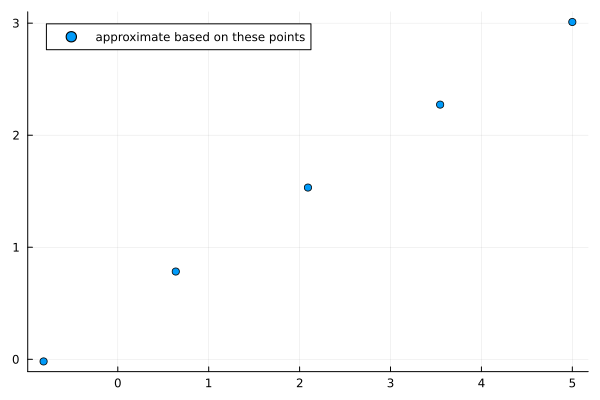

In [19]:
wgrid_sparse = range(-0.8/0.98,5.0,length = 5)

optcons_sparse = [opt_cons(w) for w in wgrid_sparse]

scatter(wgrid_sparse,optcons_sparse, label="approximate based on these points")

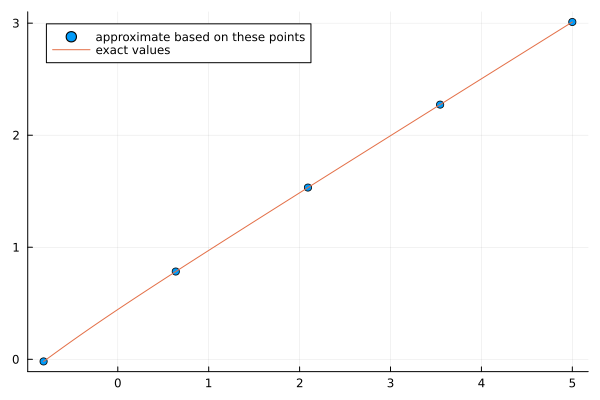

In [20]:
wgrid_dense = range(-0.8/0.98,5.0,length = 500)

optcons_dense = [opt_cons(w) for w in wgrid_dense]

plot!(wgrid_dense,optcons_dense,label = "exact values")

these lines create the approximations: one with linear interpolation, one with cubic splines.

In [21]:
approx_linear = linear_interpolation(wgrid_sparse,optcons_sparse)
approx_cubic = cubic_spline_interpolation(wgrid_sparse,optcons_sparse)

5-element extrapolate(scale(interpolate(OffsetArray(::Vector{Float64}, 0:6), BSpline(Cubic(Line(OnGrid())))), (-0.8163265306122449:1.4540816326530612:5.0,)), Throw()) with element type Float64:
 -0.018903141803582824
  0.7833544082501247
  1.5327363298109968
  2.272921538779879
  3.010320239130836

The resulting interpolated functions we can evaluate at any point like a proper function. So this works:

In [22]:
approx_linear(2.0)

1.4854069452913632

and gives a very close value to the original function:

In [23]:
opt_cons(2.0)

1.485806596201433

Let's see how close the approximations are over the whole grid:

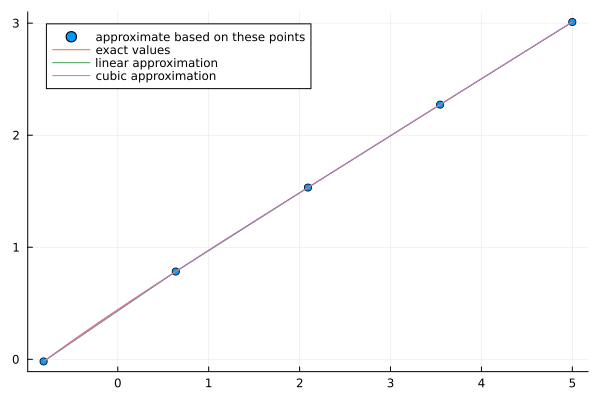

In [24]:

plot!(wgrid_dense,approx_linear.(wgrid_dense),label = "linear approximation")
plot!(wgrid_dense,approx_cubic.(wgrid_dense),label = "cubic approximation")

Since the original function was almost linear, both approximations do pretty well. To see the errors, it is more informative to look at differences from the true policy.

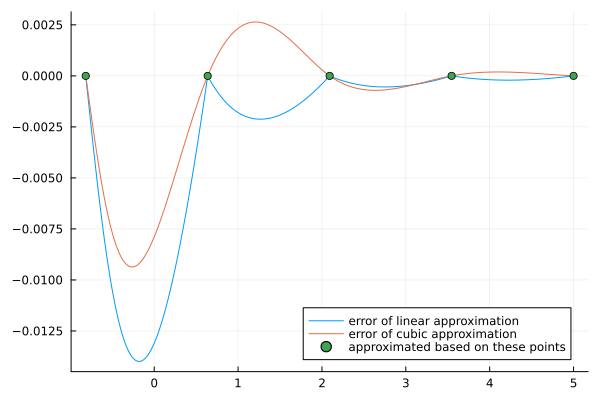

In [25]:
plot(wgrid_dense,approx_linear.(wgrid_dense).-optcons_dense,label = "error of linear approximation")
plot!(wgrid_dense,approx_cubic.(wgrid_dense).-optcons_dense,label = "error of cubic approximation")
scatter!(wgrid_sparse,fill(0.0,length(wgrid_sparse)), label="approximated based on these points")

## Optional material!

#### NLsolve

This package is made for multivariate functions, so all functions must be given as assigning vectors to vectors. Since our saving problem is univariate problem, let's test this package on the following (moderately interesting) problem
$$ 
\begin{aligned}
3 &= xy + x \\
8 &= y^3\\
\end{aligned}
$$
It is easy to check that the unique solution is $x = 1, \ y= 2$.

In [26]:
# Pkg.add("NLsolve")
using NLsolve

f(z) = [z[1]*z[2] + z[1] - 3,
        z[2]^3 - 8]
# f has to take a vector and return a vector. z should be thought of as a vector [x,y]. we look for a z such that f(z) = [0,0] (at least approximately).

sol = nlsolve(f, [0.0, 0.0]) # gave [0,0] as a starting guess for [x,y]
println(sol)
sol.zero

Results of Nonlinear Solver Algorithm
 * Algorithm: Trust-region with dogleg and autoscaling
 * Starting Point: [0.0, 0.0]
 * Zero: [1.0000000002283633, 2.0000000003046337]
 * Inf-norm of residuals: 0.000000
 * Iterations: 7
 * Convergence: true
   * |x - x'| < 0.0e+00: false
   * |f(x)| < 1.0e-08: true
 * Function Calls (f): 8
 * Jacobian Calls (df/dx): 7


2-element Vector{Float64}:
 1.0000000002283633
 2.0000000003046337

We didn't provide a function for the Jacobian, so Julia approximated it (by finite differencing - not ideal). To provide it directly, we need to use functions in 'in-place' form. This means that the function has to take a vector as an input, in which the result is filled (instead of creating the result vector inside the function)

In [27]:
function f!(fval,z)
    fval[1] = z[1]*z[2] + z[1] - 3
    fval[2] = z[2]^3 - 8
end

function f_d!(fderiv,z) # the derivative of f is a Jacobian, a 2x2 matrix
    fderiv[1,1] = z[2] + 1
    fderiv[1,2] = z[1]
    fderiv[2,1] = 0
    fderiv[2,2] = 3*z[2]^2
end

nlsolve(f!, f_d!, [0.0, 0.0])

Results of Nonlinear Solver Algorithm
 * Algorithm: Trust-region with dogleg and autoscaling
 * Starting Point: [0.0, 0.0]
 * Zero: [1.0000000002283636, 2.000000000304633]
 * Inf-norm of residuals: 0.000000
 * Iterations: 7
 * Convergence: true
   * |x - x'| < 0.0e+00: false
   * |f(x)| < 1.0e-08: true
 * Function Calls (f): 8
 * Jacobian Calls (df/dx): 7

We can of course use NLsolve to solve our original (univariate) problem, we just need to rewrite it as if it were a vector problem.

In [28]:
function value_d!(D,c)
    return D[1] = value_d(c[1],benchmark) # D and c are treated as vectors! they might have length 1, but still, they are vectors
end

function value_dd!(D,c)
    return D[1] = value_dd(c[1],benchmark)
end

nlsolve(value_d!, value_dd!, [maxcons(benchmark)/2]) # the initial point is a length-1 vector as well


Results of Nonlinear Solver Algorithm
 * Algorithm: Trust-region with dogleg and autoscaling
 * Starting Point: [0.892156862745098]
 * Zero: [0.9718408845137946]
 * Inf-norm of residuals: 0.000000
 * Iterations: 3
 * Convergence: true
   * |x - x'| < 0.0e+00: false
   * |f(x)| < 1.0e-08: true
 * Function Calls (f): 4
 * Jacobian Calls (df/dx): 4